# Skew Correction

This google colab notebook introduces basic Document Image Processing Method called **Skew Correction**. 

Skew refers to the rotation of a document image from its intended orientation. This can happen during the scanning process and can affect the readability and usability of the document image.

---

Use the following drive link to access the images.

Drive Link: https://drive.google.com/drive/folders/1ivc4ISlTaUerNKcrMZUIb1yU-wkDZW-Y


## Mounting the google drive and loading requried libraries

In [80]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [81]:
import numpy as np
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.transform import rotate
from skimage.feature import canny
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.stats import mode
import cv2
from google.colab.patches import cv2_imshow

## 2. Skew Correction: Rotate the image to deskew it

In [82]:
def plot_images(image, rotated):
  fig, axes = plt.subplots(1, 2, figsize=(15, 15))
  ax = axes.ravel()

  ax[0].imshow(image, cmap="gray")
  ax[0].set_title('Input image')
  ax[0].set_axis_off()

  ax[1].imshow(rotated, cmap="gray")
  ax[1].set_axis_off()
  ax[1].set_title('Skew Corrected')

  return

def show_detected_lines(image, edges, lines):
  # Generating Plots
  fig, axes = plt.subplots(1, 2, figsize=(15, 15))
  
  # fig.suptitle('Intermediate Lines')
  
  ax = axes.ravel()

  ax[0].imshow(image, cmap="gray")
  ax[0].set_title('Input image')
  ax[0].set_axis_off()

  ax[1].imshow(edges, cmap="gray")
  origin = np.array((0, image.shape[1]))

  # plot lines
  for _, angle, dist in lines:
      y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
      ax[1].plot(origin, (y0, y1), '-r')
      
  ax[1].set_xlim(origin)
  ax[1].set_ylim((edges.shape[0], 0))
  ax[1].set_axis_off()
  ax[1].set_title('Detected lines')

  return

In [83]:
#@title Final Algorithm

# skew detecttion
def detect_skew(image:np.ndarray, show_interm=False)->float:
  # convert to edges
  edges = canny(image)
  # Classic straight-line Hough transform between 0.1 - 180 degrees.
  angles = np.deg2rad(np.arange(0.1, 180.0))
  h, theta, d = hough_line(edges, theta=angles)
  
  # find line peaks and angles
  accum, angles, dists = hough_line_peaks(h, theta, d,threshold=0.05* max(d))
  lines = zip(accum, angles, dists)

  if show_interm:
    show_detected_lines(image, edges, lines)
  
  # round the angles to 3 decimal places and find the most common angle.
  dominant_angle = mode(np.around(angles, decimals=3), keepdims=False)[0]
  
  # convert the angle to degree for rotation.
  skew_angle = np.rad2deg(dominant_angle - np.pi/2)

  return skew_angle

def preprocessing(image:np.ndarray, noprep=True):
  if len(image.shape)>2:
    denoised = cv2.fastNlMeansDenoisingColored(image, None, h=10, templateWindowSize=7, searchWindowSize=21)
    image = rgb2gray(denoised[:,:,:3])

  if not noprep:
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    # Apply image denoising
    denoised = cv2.fastNlMeansDenoising(blur, None, h=10, templateWindowSize=7, searchWindowSize=21)
      
    # Apply binary thresholding
    _, binary = cv2.threshold(denoised, 127, 255, cv2.THRESH_BINARY)

    return binary
  else:
    return image

# rotate Image
def deSkew(image:np.ndarray, skew_angle:float)->np.ndarray:
  '''rotate the image to deskew it'''
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  
  R = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
  rotated = cv2.warpAffine(image, R, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

  return rotated

def post_processing(rotated: np.ndarray)->np.ndarray:
  # Hint: The images don't look crisp!
  pass
  return rotated

def textdilationElementWise(binary_image,iterations=3):
  '''
  binary image : text = 1 bg = 0 
  '''
  # Small local kernel that tickens the existing text more closely
  text_kernel = np.ones((3,3))
  dilated_image = cv2.dilate(binary_image,text_kernel,iterations)
  return dilated_image

def SkewCorrection(path, verbose=False, noprep=True):
  # read Image
  image = imread(path)
  blurred = cv2.GaussianBlur(image, (5, 5), 0)
  image_pre =  preprocessing(blurred, noprep)

  thickTextDocument = 255- textdilationElementWise(255-image_pre,iterations=2)
  image_pre = thickTextDocument
  
  if not noprep:  
    plt.title('After Preprocessing')
    plt.imshow(image_pre, cmap='gray')

  # determine angle
  skew_angle = detect_skew(image_pre, verbose)


  
  if verbose:
    print(f'Skew Angle is {skew_angle:.3f}')

  # Rotate Image
  rotated = deSkew(image, skew_angle)

  # post processing!
  rotated_final = post_processing(rotated)
  
  print('\n\n\n')
  
  # plot images
  plot_images(image, rotated_final)


  return rotated_final

Skew Angle is -24.912






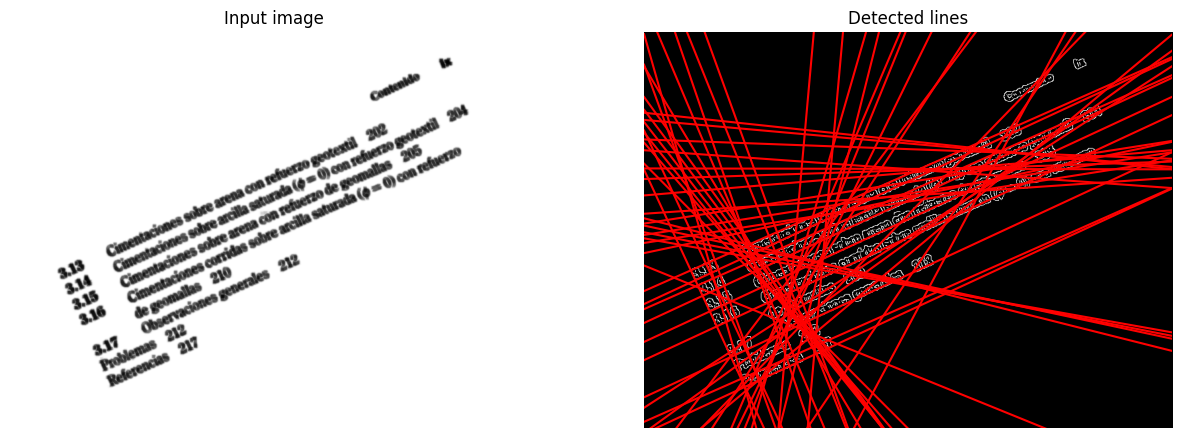

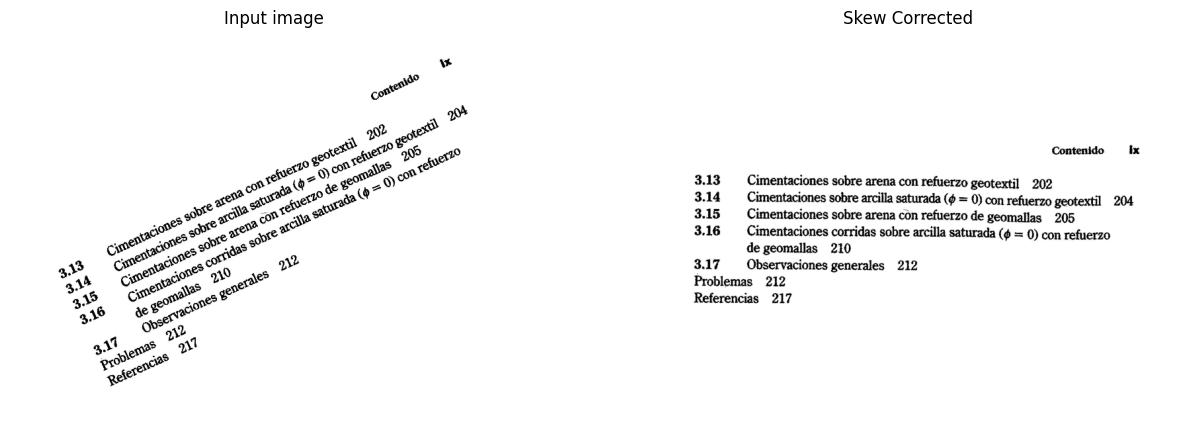

In [84]:
deSkewed_img = SkewCorrection('drive/MyDrive/Workshop/skewimages/skew/easy/1.png', verbose=True)

Skew Angle is -29.897






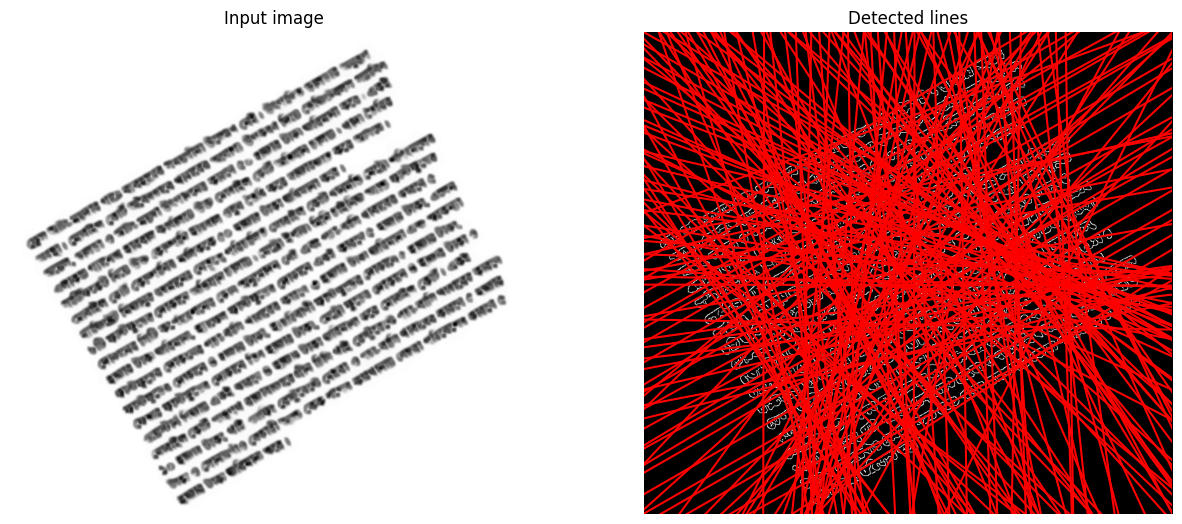

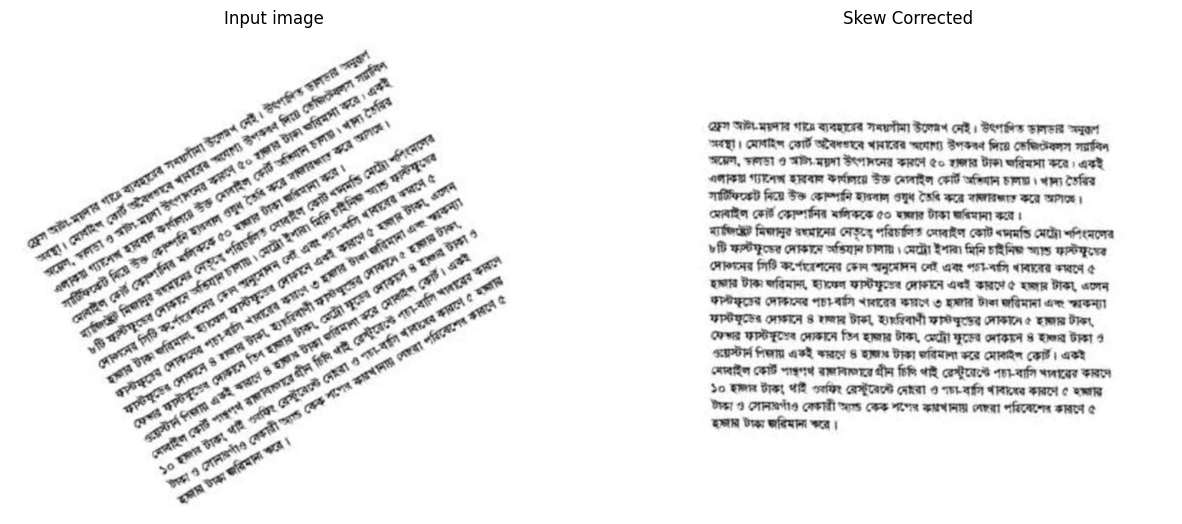

In [85]:
deSkewed_img = SkewCorrection('drive/MyDrive/Workshop/skewimages/skew/easy/7.png', verbose=True)

Skew Angle is 23.102






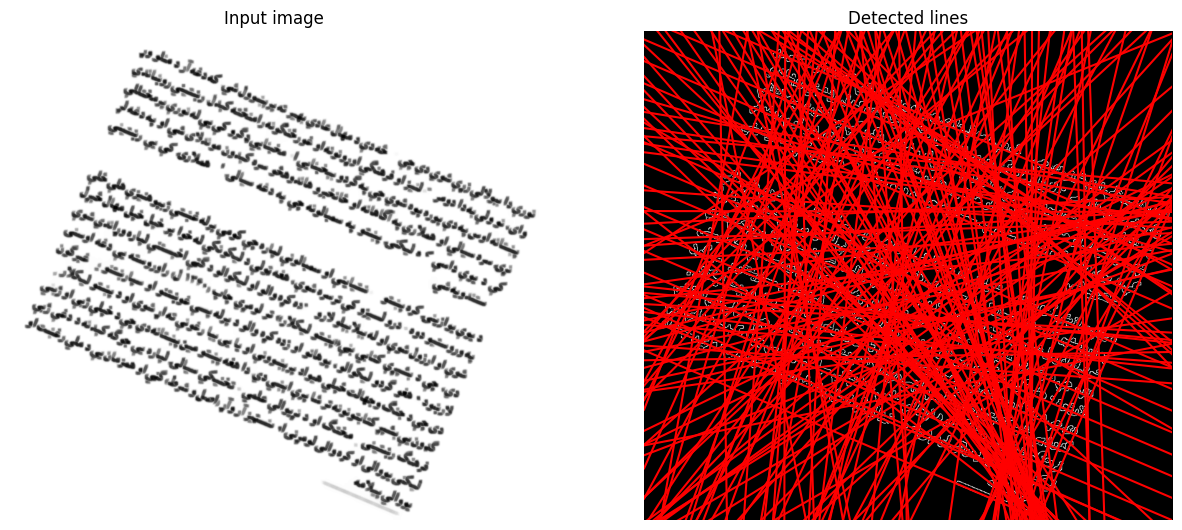

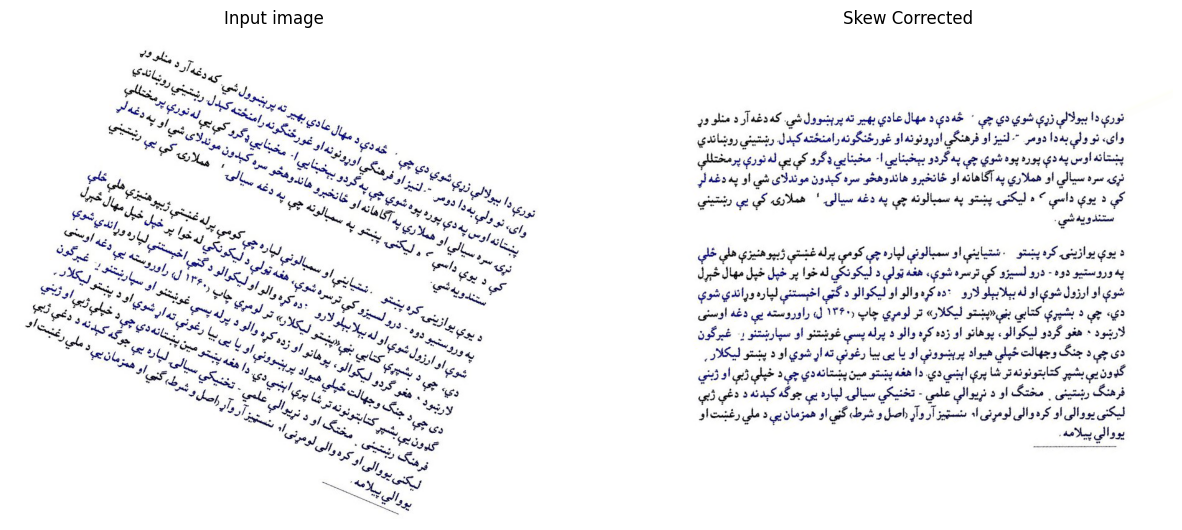

In [79]:
deSkewed_img = SkewCorrection('drive/MyDrive/Workshop/skewimages/skew/easy/8.png', verbose=True)

Skew Angle is 0.126






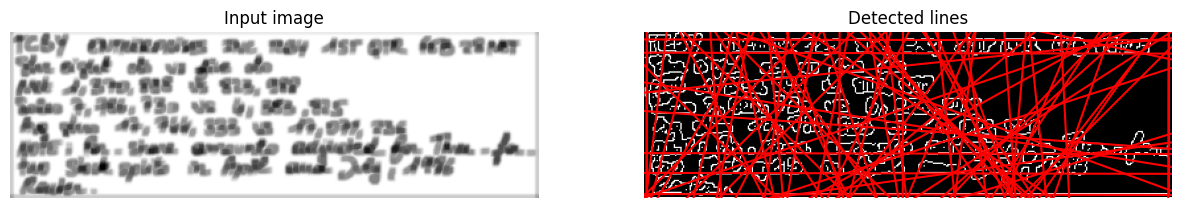

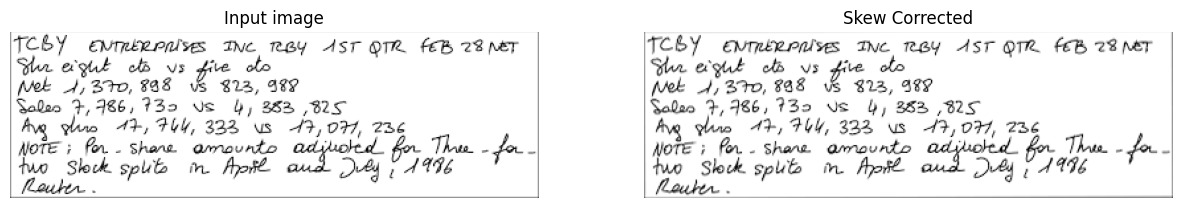

In [86]:
deSkewed_img = SkewCorrection('drive/MyDrive/Workshop/skewimages/skew/easy/9.png', verbose=True)

Skew Angle is 62.120






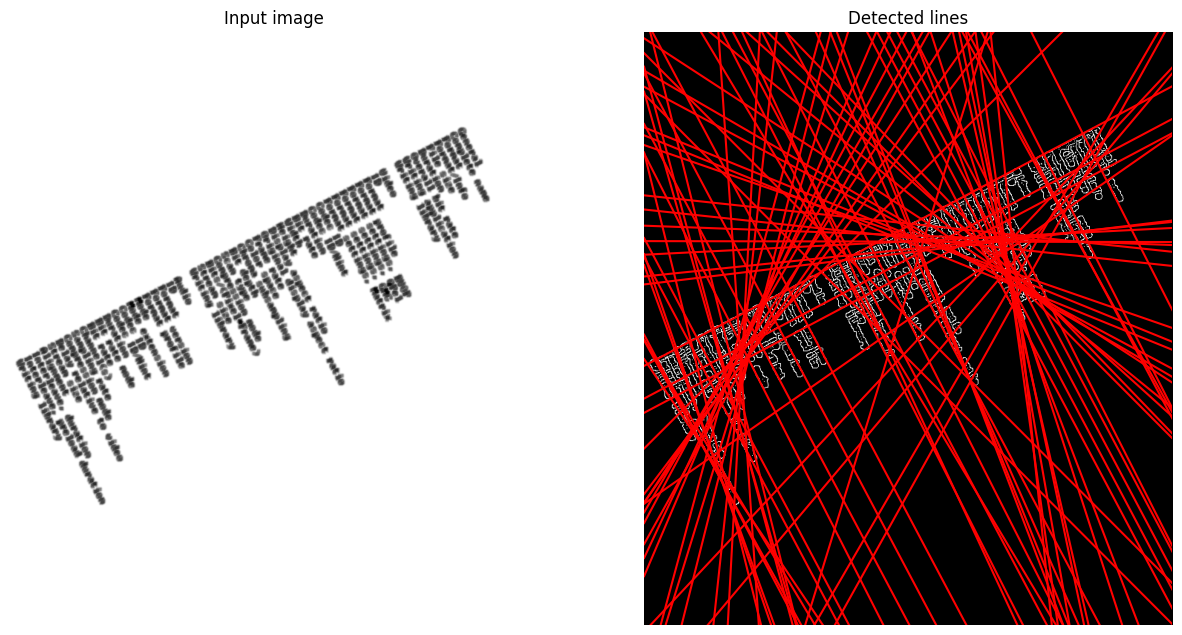

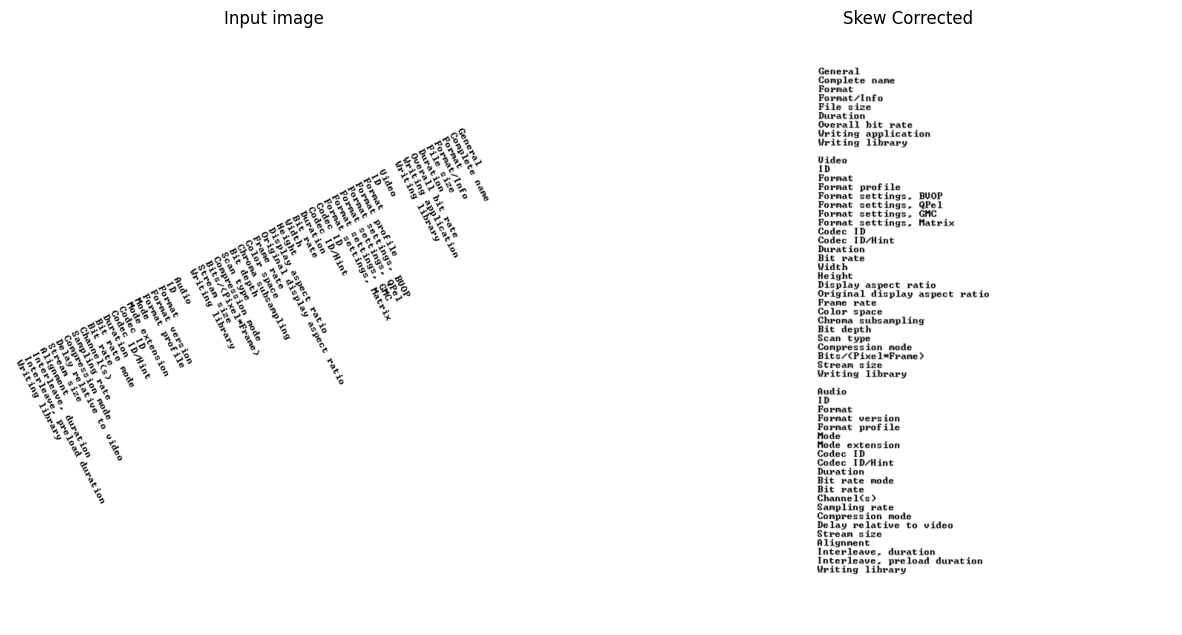

In [87]:
deSkewed_img = SkewCorrection('drive/MyDrive/Workshop/skewimages/skew/tough/5.png', verbose=True)

Skew Angle is -24.912






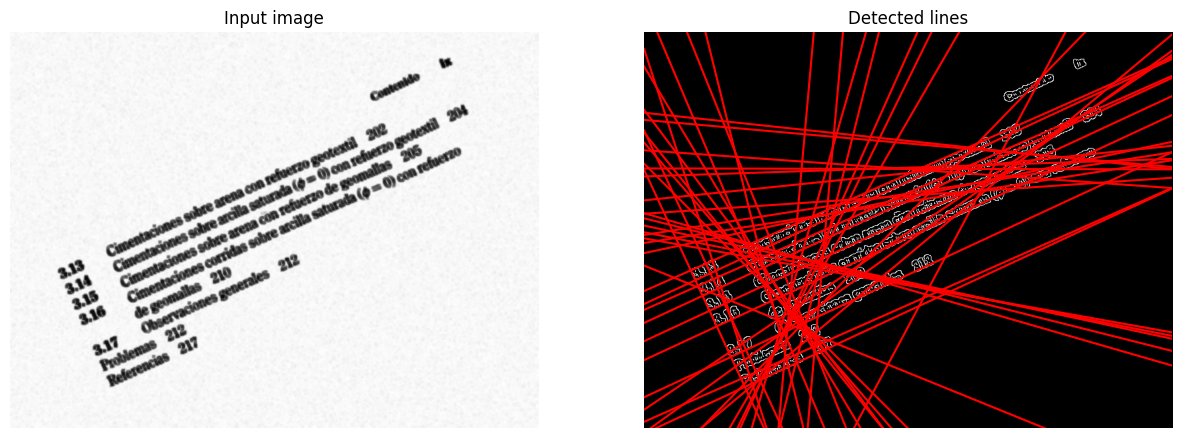

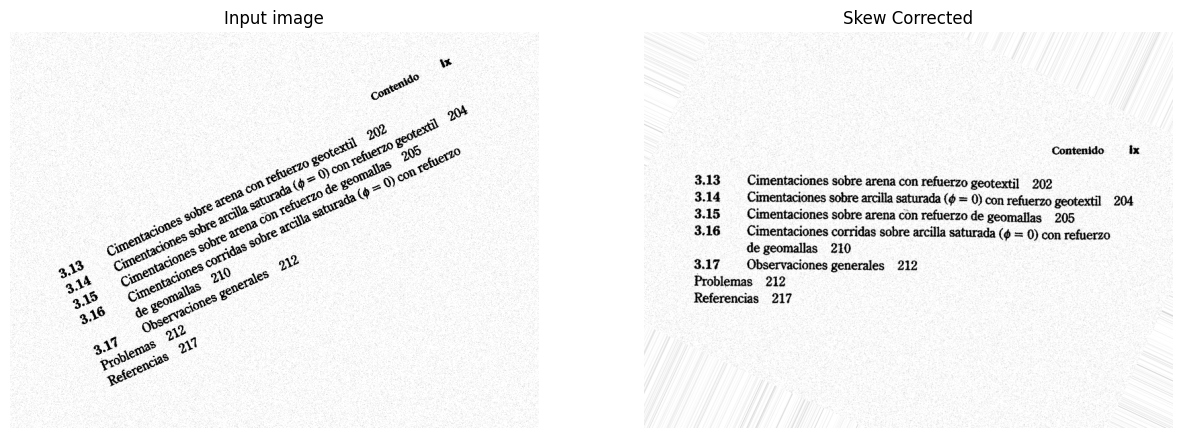

In [88]:
deSkewed_img = SkewCorrection('drive/MyDrive/Workshop/skewimages/skew/med/1_pn.png', verbose=True)

Skew Angle is -24.912






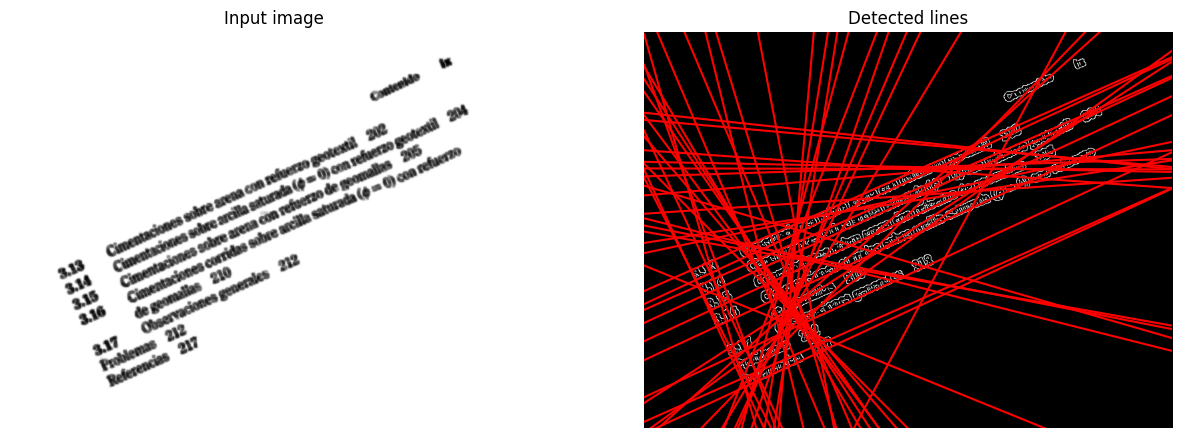

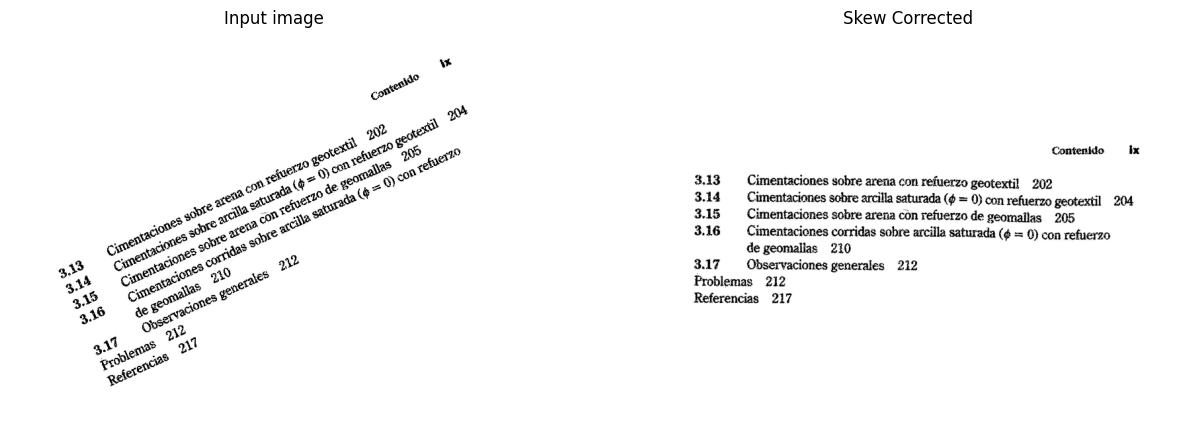

In [89]:
deSkewed_img = SkewCorrection('drive/MyDrive/Workshop/skewimages/skew/med/1_s.png', verbose=True)

There is no One-size-fits-all solution!!
- Possible solutions: Compute the minimum rotated bounding Bounding Rectangle.